In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

pd.pandas.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./data/sample.csv')
df['id'] = df.index + 1
print(df.shape)
df.head()

(29236, 18)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,id
0,2,2017-03-06 12:10,2017-03-06 12:20,2,2.03,1,N,140,236,1,9.0,0.0,0.5,1.96,0.0,0.3,11.76,1
1,1,2017-06-14 8:11,2017-06-14 8:14,1,0.40,1,N,43,142,1,4.5,0.0,0.5,1.05,0.0,0.3,6.35,2
2,2,2017-11-22 19:42,2017-11-22 19:49,3,1.04,1,N,151,238,1,6.5,1.0,0.5,0.00,0.0,0.3,8.30,3
3,2,2017-11-12 16:58,2017-11-12 17:09,1,1.79,1,N,239,236,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30,4
4,1,2017-06-14 22:01,2017-06-14 22:06,1,1.20,1,N,246,246,1,6.0,0.5,0.5,2.15,0.0,0.3,9.45,5


In [3]:
# train, test split
# set seed for reproducibility 

X_train, X_test, y_train, y_test = train_test_split(df, df.tip_amount,
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26312, 18), (2924, 18), (26312,), (2924,))

### Time variable

In [4]:
def trip_time(df, start, end):
    """
    start: pickup time
    end: dropoff time
    
    Extracts time information from the two variables. 
    """
    df = df.copy()
    
    df['pickup'] = pd.to_datetime(df[start])
    df['dropoff'] = pd.to_datetime(df[end])
    
    df['trip_time'] = df['dropoff'] - df['pickup']
    
    # convert to minutes
    df['trip_seconds'] = df['trip_time'].astype('timedelta64[s]')
        
    df = df.drop(columns=[start, end, 'trip_time', 'pickup', 'dropoff'])
    
    return df

In [5]:
X_train = trip_time(X_train, 'tpep_pickup_datetime', 'tpep_dropoff_datetime')
X_test = trip_time(X_test, 'tpep_pickup_datetime', 'tpep_dropoff_datetime')

In [6]:
X_train.shape

(26312, 17)

### Numerical variables
- Log transform those without zeros to get a more Gaussian distribution to help linear machine learning models

In [7]:
# remove negative values columns where it is not possible to have negative values
cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
for col in cols:
    X_train = X_train[X_train[col] >= 0]
    X_test = X_test[X_test[col] >= 0]
    
# remove zero values from where it is not possible to have zero values
cols = ['fare_amount', 'total_amount']
for col in cols:
    X_train = X_train[X_train[col] > 0]
    X_test = X_test[X_test[col] > 0]
    
X_train.describe()

# log transform numeric variables that do not contain zeros
for var in ['fare_amount', 'total_amount']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

### Categorical variables
- convert strings to numbers to capture monotonic relationship between label and target

In [8]:
# for one hot encoding
# a few variables have been coded as an int instead of a categorical variable
var_to_str = ['RatecodeID', 'store_and_fwd_flag', 'payment_type']

def to_str(train, test, var):
    train[var] = train[var].astype(str)
    test[var] = test[var].astype(str)
    
for var in var_to_str:
    to_str(X_train, X_test, var)

In [9]:
# check cardinality of non-numeric features we want to one-hot encode
X_train.describe(include='O').T.sort_values(by='unique')

,count,unique,top,freq
store_and_fwd_flag,26285,2,N,26143
payment_type,26285,4,1,17895
RatecodeID,26285,6,1,25515


In [10]:
X_train.RatecodeID.value_counts(normalize=False)

1     25515
2       609
5        85
3        61
4        14
99        1
Name: RatecodeID, dtype: int64

In [11]:
X_train.payment_type.value_counts(normalize=False)

1    17895
2     8239
3      113
4       38
Name: payment_type, dtype: int64

In [12]:
# need to reduce cardinality of PULocationID & DOLocationID
X_train.PULocationID.value_counts().sum

# get list of top 10 locations
top10PU = X_train['PULocationID'].value_counts()[:10].index
top10DO = X_train['DOLocationID'].value_counts()[:10].index

# for locationIDs not in the top 10, replace with OTHER
X_train.loc[~X_train['PULocationID'].isin(top10PU), 'PULocationID'] = 'OTHER'
X_train.loc[~X_train['DOLocationID'].isin(top10DO), 'DOLocationID'] = 'OTHER'

X_test.loc[~X_test['PULocationID'].isin(top10PU), 'PULocationID'] = 'OTHER'
X_test.loc[~X_test['DOLocationID'].isin(top10DO), 'DOLocationID'] = 'OTHER'

In [13]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

X_train['RatecodeID'] = X_train['RatecodeID'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five', '99': 'six'})
X_test['RatecodeID'] = X_test['RatecodeID'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five', '99': 'six'})

X_train['store_and_fwd_flag'] = X_train['store_and_fwd_flag'].replace({'1': 'one', '2': 'two'})
X_test['store_and_fwd_flag'] = X_test['store_and_fwd_flag'].replace({'1': 'one', '2': 'two'})

X_train['payment_type'] = X_train['payment_type'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four'})
X_test['payment_type'] = X_test['payment_type'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four'})

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.fit_transform(X_test)

X_train_encoded.head()

,VendorID,passenger_count,trip_distance,RatecodeID_one,RatecodeID_two,RatecodeID_five,RatecodeID_three,RatecodeID_four,RatecodeID_six,store_and_fwd_flag_N,store_and_fwd_flag_Y,PULocationID_170,PULocationID_48,PULocationID_OTHER,PULocationID_230,PULocationID_162,PULocationID_236,PULocationID_237,PULocationID_234,PULocationID_142,PULocationID_186,PULocationID_161,DOLocationID_186,DOLocationID_OTHER,DOLocationID_236,DOLocationID_48,DOLocationID_170,DOLocationID_162,DOLocationID_230,DOLocationID_161,DOLocationID_142,DOLocationID_237,DOLocationID_234,payment_type_one,payment_type_two,payment_type_three,payment_type_four,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,id,trip_seconds
18162,1,1,1.00,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.704748,0.5,0.5,1.35,0.0,0.3,2.098018,18163,240.0
18257,2,1,1.35,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1.871802,0.5,0.5,1.56,0.0,0.3,2.236445,18258,420.0
2574,2,1,0.52,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1.386294,0.0,0.5,0.00,0.0,0.3,1.568616,2575,120.0
7141,1,1,1.40,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2.014903,1.0,0.5,0.00,0.0,0.3,2.230014,7142,480.0
6020,2,1,3.03,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2.708050,0.5,0.5,0.00,0.0,0.3,2.791165,6021,1260.0


In [14]:
X_train_encoded.shape, X_train.shape

((26285, 46), (26285, 17))

In [15]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
cat_vars

['RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type']

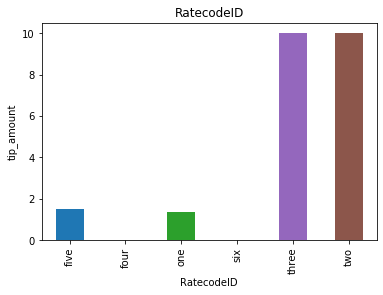

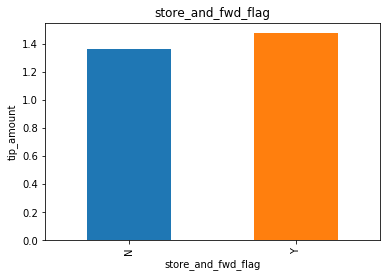

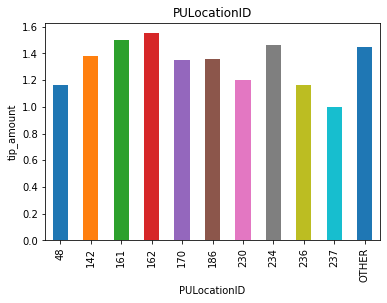

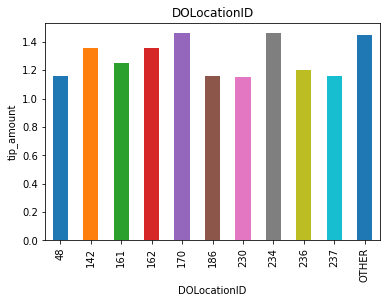

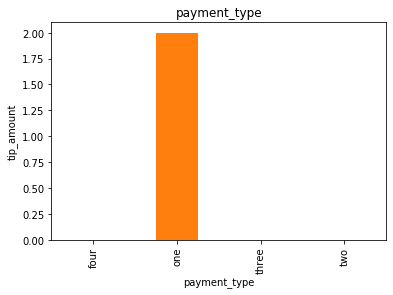

In [16]:
# is there a monotonic relationship between the labels and tip amount?
def analyse_vars(df, var):
    df = df.copy()
    df.groupby(var)['tip_amount'].median().plot.bar()
    plt.title(var)
    plt.ylabel('tip_amount')
    plt.show()
    
for var in cat_vars:
    analyse_vars(X_train, var)

### Feature scaling
- for linear models

In [17]:
features = [var for var in X_train_encoded.columns if var not in ['id', 'tip_amount']]

X_train_encoded[['id', 'tip_amount']].reset_index(drop=True)
# X_train_encoded = X_train_encoded[features]
# X_test_encoded = X_test_encoded[features]

,id,tip_amount
0,18163,1.35
1,18258,1.56
2,2575,0.00
3,7142,0.00
4,6021,0.00
5,15660,0.78
6,7703,1.95
7,12339,5.35
8,22803,0.00
9,6860,2.25


In [18]:
scaler = MinMaxScaler()
scaler.fit(X_train_encoded[features])

X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.fit_transform(X_test_encoded)



In [19]:
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((26285, 46), (26312,), (2923, 45), (2924,))

In [20]:
X_train_scaled = pd.concat([X_train_encoded[['id', 'tip_amount']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_train_encoded[features]), columns=features)],
                    axis=1)

X_test_scaled = pd.concat([X_test_encoded[['id', 'tip_amount']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_test_encoded[features]), columns=features)],
                    axis=1)

ValueError: operands could not be broadcast together with shapes (26285,44) (45,) (26285,44) 

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train_scaled, y_train)

print('Test accuracy', model.score(X_test_scaled, y_test))